In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/winter-2025-machine-learning-competition-1-p/sample_submission.csv
/kaggle/input/winter-2025-machine-learning-competition-1-p/train.csv
/kaggle/input/winter-2025-machine-learning-competition-1-p/test.csv


In [19]:
train = pd.read_csv('/kaggle/input/winter-2025-machine-learning-competition-1-p/train.csv')
test = pd.read_csv('/kaggle/input/winter-2025-machine-learning-competition-1-p/test.csv',index_col=[0])

In [5]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [25]:
train_df = train.copy()
y = train_df.pop("Label")
X = train_df.drop(['X1','X3'],axis=1)
test = test.drop(['X1','X3'],axis=1)

In [7]:
# get a list of models to evaluate
def get_models():
    models = {
        'xgb':xgb.XGBClassifier(eval_metric='logloss',n_estimators = 1500,eta=.03,subsample=.75,
                          scale_pos_weight = pos_class_weight,objective='binary:logistic',
                          max_delta_step=1),
        'gbm':GradientBoostingClassifier(n_estimators=250, learning_rate=.01,max_depth=3, random_state=0),
        'rf':RandomForestClassifier(n_estimators=225,n_jobs=-1,random_state=0),
#        'stack':get_stacking()
        }
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='roc_auc_ovr', cv=cv, n_jobs=-1, error_score='raise')
	return scores

def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('rf', RandomForestClassifier(n_estimators=225,n_jobs=-1,random_state=0)))
	#level0.append(('lda', LDA()))
	level0.append(('xgb', xgb.XGBClassifier(eval_metric='logloss',n_estimators = 1500,eta=.03,subsample=.75,
                          scale_pos_weight = pos_class_weight,objective='binary:logistic',
                          max_delta_step=1)))
	level0.append(('gbm', GradientBoostingClassifier(n_estimators=250, learning_rate=.01,max_depth=3, random_state=0)))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [6]:
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>rf 0.944 (0.015)


In [8]:
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>xgb 0.973 (0.013)
>gbm 0.937 (0.016)
>rf 0.944 (0.015)


# Is XGBoost the most stable model?

In [33]:
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)
xgb_model = xgb.XGBClassifier(eval_metric='logloss',n_estimators = 1500,eta=.03,subsample=.75,
                          scale_pos_weight = pos_class_weight,objective='binary:logistic',
                          max_delta_step=1,verbosity=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb_model, X, y, scoring='roc_auc_ovr', cv=cv, n_jobs=-1, error_score='raise')

{'whiskers': [<matplotlib.lines.Line2D at 0x7e5b84521960>,
 'caps': [<matplotlib.lines.Line2D at 0x7e5b84521de0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e5b845216c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e5b84522230>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e5b845224d0>],
 'means': []}

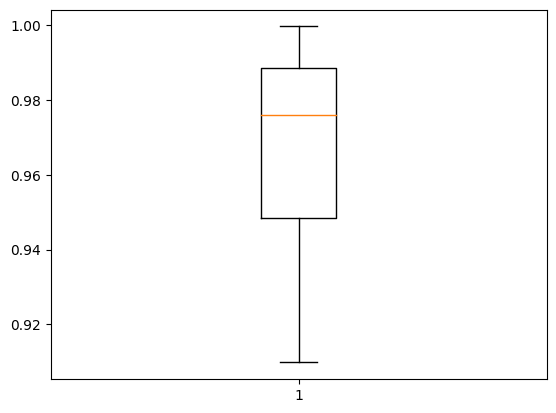

In [37]:
plt.boxplot(scores)

In [36]:
np.mean(scores),np.std(scores)

(0.9680211643449603, 0.024768785197646144)

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss',n_estimators = 1500,eta=.03,subsample=.75,
                          scale_pos_weight = pos_class_weight,objective='binary:logistic',
                          max_delta_step=1,verbose=0)
xgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])

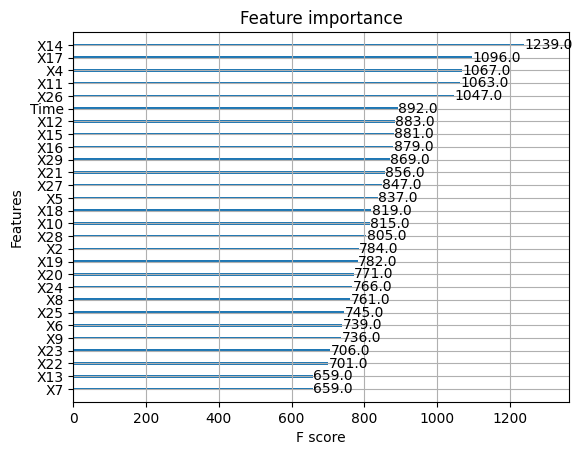

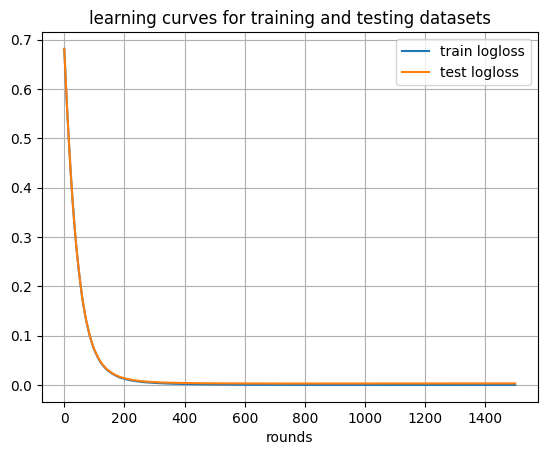

In [21]:
xgb.plot_importance(xgb_model)
plt.figure()
results = xgb_model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train logloss')
plt.plot(results['validation_1']['logloss'], label='test logloss')
# plt.plot(results['validation_0']['auc'],label="train auc")
# plt.plot(results['validation_1']['auc'],label="test auc")
plt.legend()
plt.grid()
plt.xlabel("rounds")
plt.title("learning curves for training and testing datasets")
plt.show()

In [22]:
test_probs = xgb_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,test_probs,max_fpr=.01)
# best so far is .93209 w/ eval_metric = "logloss",.03 eta, 1500 n_iter, and subsample=.75

0.9301200289285452

In [26]:
pred_test = xgb_model.predict_proba(test)[:, 1]
#for item in pred_test:
#    print(item)

In [27]:
submission = pd.DataFrame({'id':test.index, 'Label':pred_test})
submission.set_index('id').to_csv("submission.csv") # .9316229 auc score :(

# Test the stability of RF

In [28]:
train = pd.read_csv('/kaggle/input/winter-2025-machine-learning-competition-1-p/train.csv')
test = pd.read_csv('/kaggle/input/winter-2025-machine-learning-competition-1-p/test.csv',index_col=[0])
train_df = train.copy()
y = train_df.pop("Label")
X = train_df.drop(['X1','X3','X13','X7'],axis=1)
test = test.drop(['X1','X3','X13','X7'],axis=1)

In [29]:
# need to rerun
rf_model = RandomForestClassifier(n_estimators=225,n_jobs=-1,random_state=0,class_weight = 'balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf_model, X, y, scoring='roc_auc_ovr', cv=cv, n_jobs=-1, error_score='raise')

{'whiskers': [<matplotlib.lines.Line2D at 0x7e5b94d5b700>,
 'caps': [<matplotlib.lines.Line2D at 0x7e5b94d5bc40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e5b94d5b460>],
 'medians': [<matplotlib.lines.Line2D at 0x7e5b94d58be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e5b94d58c70>],
 'means': []}

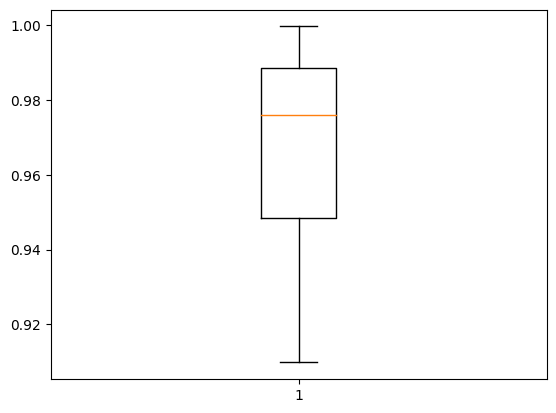

In [31]:
plt.boxplot(scores)

In [32]:
np.mean(scores),np.std(scores)

(0.9680211643449603, 0.024768785197646144)